<a href="https://colab.research.google.com/github/spacemaninSeoul/justpractice/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

해결하려는 문제에서 빠른 속도로 일정 수준의 베이스라인 성능을 얻고 싶을 때, 어떻게 보면 가장 쉽고 빠른 방법인 **전이 학습(transfer learning)**을 알아보도록 한다. 전이 학습의 핵심은 사전 학습(pre-trained)된 네트워크의 가중치를 사용하는 것이다. 전이 학습은 크게 세 가지로 분류할 수 있다.

  - 모델을 변형하지 않고 사용하는 방법
  - 모델의 분류기를 재학습하는 방법(기본적으로 가장 많이 사용된다)
  - 모델의 일부를 동결 해제하여 재학습하는 방법
  

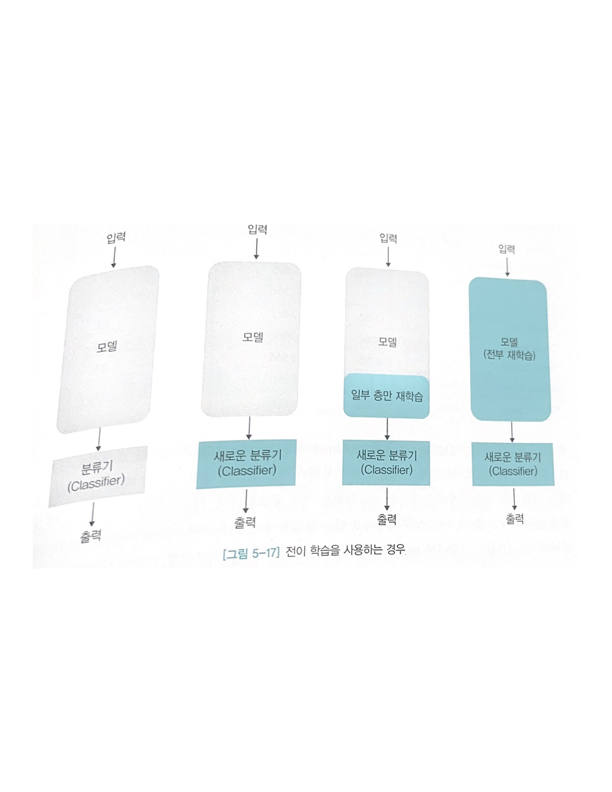

전이 학습을 주로 ImageNet 데이터를 학습시킨 가중치를 사용하거나 본인만의 데이터셋을 사용하여 재학습을 진행하는데, 이를 **미세 조정(fine-tuning)**이라고 한다. 케라스는 사전 학습된 모델을 다양하게 제공한다. (https://keras.io/applications)

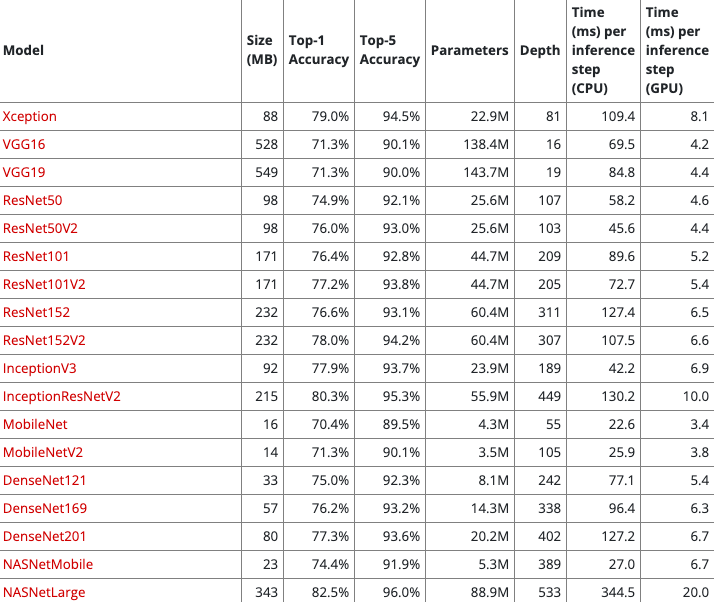

위 표는 모델의 용량, 성능(Top-1 정확도,Top-5 정확도), 파라미터 수, 깊이를 보여주고 있다. 우리가 사용할 데이터셋에서 어떤 구조의 모델이 최고 성능을 낼지 모르기 때문에, 다양한 모델을 사용하여 학습시켜보고 결과를 비교해보는 것도 중요하다. 데이터셋에 적합한 크기의 모델을 결정하려고 할 때, 케라스가 제공하고 있는 모델을 우선 사용하여 기준을 마련해두고 크기를 결정하기도 한다.

여기선 ImageNet 데이터로 사전 학습된 가중치를 사용한 VGG16 모델을 사용하도록 한다.
(http://www.image-net.org)

In [1]:
# 전이 학습 사용해보기
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16

# ImageNet 데이터를 학습한 모델을 불러온다.
vgg16 = VGG16(weights = 'imagenet', input_shape = (32, 32, 3), include_top = False)

model = Sequential()
model.add(vgg16)

# 분류기 직접 정의한다.
model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(10, activation = 'softmax'))

model.summary() # 모델 구조 확인

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                25

VGG16 모델뿐만 아니라 다음과 같이 다양한 모델을 사용할 수 있다.

In [2]:
# 케라스가 제공하는 다양한 모델
'''
from tensorflow.keras.applications import *
mobilenet = MobileNet(weights = None, input_shape = None, include_top = True)
resnet50 = ResNet50(weights = None, input_shape = None, include_top = True)
xception = Xception(weights = None, input_shape = None, include_top = True)
'''

'\nfrom tensorflow.keras.applications import *\nmobilenet = MobileNet(weights = None, input_shape = None, include_top = True)\nresnet50 = ResNet50(weights = None, input_shape = None, include_top = True)\nxception = Xception(weights = None, input_shape = None, include_top = True)\n'

케라스가 제공하는 사전 학습된 모델을 사용하는 경우, 주로 세 가지 인자를 사용한다.
  - weights : ImageNet 데이터를 학습시킨 가중치의 사용 여부를 결정한다. 기본값은 None이며, 가중치를 사용하고 싶다면 'imagenet'을 전달해야 한다.
  - input_shape : 입력 데이터의 형태를 전달한다.
  - include_top : 모델의 분류기층을 포함해서 구성할지를 결정한다. False를 전달할 경우, 위의 코드처럼 데이터셋에 적합한 분류기를 직접 정의해야 한다.

VGG16 모델은 전이 학습의 예로 사용되는 가장 기본적인 모델이다. 이는 단순하게 컨볼루션층과 최대 풀링층의 반복으로 구성되어 있어 모델을 쉽게 이해할 수 있기 때문이다. ImageNet 데이터를 학습한 모델은 엄청난 수의 이미지 데이터를 학습했기 때문에 직접 모델을 구성하여 처음부터 학습하는 것보다 더 좋은 결과를 기대할 수 있다. **하지만 사용하는 데이터셋의 특성이 고유하다면, 모델의 일부분만 동결을 해제시키고 학습시켜볼 필요가 있다** 동결 해제는 다음과 같다.

In [3]:
# 모델 동결 해제하기
# 끝의 네 개 층만 동결을 해제한다.
for layer in vgg16.layers[:-4]:
  layer.trainable = False

위의 예제 코드를 수행하면 학습 과저엥서 VGG16 모델의 끝에 구성된 네 개 층은 학습을 통해 가중치가 재조정되며, 그 외의 층은 학습하지 않는다. 모델의 끝에 구성된 층을 동결 해제하는 이유는 **모델의 상위층(출력과 가까운 층)에서 데이터의 구체적인 특성을 학습하고, 하위층(입력과 가까운 층)에서는 단순한 특징을 학습하기 때문이다.** 얼굴을 예로 들면, 모델의 상위층은 입의 모양, 눈의 모양, 코의 모양과 같이 좀 더 구체적인 특징을 학습하고, 모델의 하위층은 얼굴의 모양을 학습한다. 많은 사람을 구분하기 위해서는 얼굴 모양이 아닌 입의 모양, 눈의 모양 같이 구체적인 특징을 학습해야 할 것이다.

다음 코드를 통해 동결 해제된 모델을 학습한다.



In [4]:
# 전이 학습을 통해 학습하기
model = Sequential()
model.add(vgg16)

# 분류기를 직접 정의한다.
model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(10, activation='softmax'))

model.summary() # 모델 구조 확인하기


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                2570      
                                                      

In [5]:
from tensorflow.keras.datasets import cifar10
import numpy as np

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 평균과 표준편차는 채널별로 구해줍니다.
x_mean = np.mean(x_train, axis = (0, 1, 2))
x_std = np.std(x_train, axis = (0, 1, 2))

x_train = (x_train - x_mean) / x_std
x_test = (x_test - x_mean) / x_std

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                  test_size = 0.3, random_state = 777)

# sparse_categorical_crossentropy를 사용하기 위해선 (batch_size, ) 형태를 가져야합니다.
# 따라서 np.squeeze를 사용해서 마지막 차원을 없애줍니다.
# y_train의 경우 (35000, 1) -> (35000, )이 됩니다.
y_train = np.squeeze(y_train)
y_val = np.squeeze(y_val)



170508288/170498071 [==============================] - 2s 0us/step


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32

train_datagen = ImageDataGenerator(horizontal_flip = True,
                                   zoom_range = 0.2,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   rotation_range = 30,
                                   fill_mode = 'nearest')
train_generator = train_datagen.flow(x_train, y_train,
                                    batch_size = batch_size)

val_datagen = ImageDataGenerator()
val_generator = val_datagen.flow(x_val, y_val,
                                batch_size = batch_size)


In [7]:
model.compile(optimizer = Adam(1e-4), loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

def get_step(train_len, batch_size):
  if (train_len % batch_size > 0):
    return train_len // batch_size + 1
  else:
    return train_len // batch_size

history = model.fit(train_generator, epochs = 100, steps_per_epoch= get_step(len(x_train), batch_size), validation_data = val_generator, validation_steps = get_step(len(x_val), batch_size))

Epoch 1/100
1094/1094 [==============================] - 62s 46ms/step - loss: 1.1267 - acc: 0.6087 - val_loss: 0.9378 - val_acc: 0.6767
Epoch 2/100
1094/1094 [==============================] - 51s 46ms/step - loss: 0.9241 - acc: 0.6785 - val_loss: 0.8744 - val_acc: 0.7018
Epoch 3/100
1094/1094 [==============================] - 51s 46ms/step - loss: 0.8538 - acc: 0.7019 - val_loss: 0.8037 - val_acc: 0.7229
Epoch 4/100
1094/1094 [==============================] - 50s 46ms/step - loss: 0.8050 - acc: 0.7197 - val_loss: 0.7655 - val_acc: 0.7343
Epoch 5/100
1094/1094 [==============================] - 50s 46ms/step - loss: 0.7756 - acc: 0.7297 - val_loss: 0.7239 - val_acc: 0.7517
Epoch 6/100
1094/1094 [==============================] - 50s 46ms/step - loss: 0.7376 - acc: 0.7433 - val_loss: 0.6594 - val_acc: 0.7701
Epoch 7/100
1094/1094 [==============================] - 49s 45ms/step - loss: 0.7102 - acc: 0.7511 - val_loss: 0.6728 - val_acc: 0.7700
Epoch 8/100
1094/1094 [==================

# TensorFlow Hub

전이 학습은 사전 학습된 가중치를 사용하는 것이라 하였다. 또, 좋은 성능을 얻기 위해 사전 학습된 가중치를 우리가 가진 데이터셋에 어떻게 전이시킬까에 대한 고민도 매우 중요하다. 하지만 사전 학습된 가중치가 존재해야 이러한 고민을 시작할 수 있다. 사전 학습된 가중치의 조건은 다음과 같이 생각해볼 수 있다.
  1. 우리가 해결하려는 문제와 특성이 동일해야 하고,
  2. 양과 질이 보장된 데이터 셋을 사용해야하고,
  3. 학습에 사용된 데이터가 문제를 어느 정도 일반화할 수 있어야 한다.

우리는 이미 위의 조건에 해당하는 사전 학습된 가중치를 VGG16 모델에 불러와 사용해보았다. 사전 학습된 가중치는 ImageNet 데이터를 학습해서 만들어졌다. 그렇다면 ImageNet 데이터를 사용하여 우리가 직접 사전 학습된 가중치를 만들 수 있을까? 아마 불가능할 것이다. 엄청나게 많은 GPU가 필요할지도 모르기 때문이다.

텐서플로 2.x는 이런 고민을 해결하기 위해 텐서플로 허브(TensorFlow Hub, https://tfhub.dev )를 제공한다. 이 것의 목적은 우리가 원하는 사전 학습된 모델을 쉽게 찾을 수 있도록 도와주는 것이다.